In [1]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

def xlsx2D_to_df1D(xlsx_path, sheet, data_col):
    df = pd.read_excel(xlsx_path, sheet_name=sheet, index_col=0)
    df = df.unstack().reset_index(name=data_col) # unpivot (linearize) the table
    df.rename(columns={'level_1': 'antigen_row', 'level_0': 'antigen_col'}, inplace=True)
    df = df[['antigen_row', 'antigen_col', data_col]]
    return df

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  Scienion pipeline reports intensities over 30 spots out of 36. It omits 5 fiducials and 1 empty spot.
* Human reference plasma's starting dilution was 0.001 like all other plasma.


# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots

In [2]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigeninfo_path=os.path.join(data_folder,'robin_antigens.xlsx')

In [3]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)

# It is better to keep sera ID separated by day.
# serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True)
# serum_day_df.fillna(0, inplace=True)
# serum_day_df.columns=['serum', 'day']
# serum_day_df['day'] = serum_day_df['day'].astype(int)
# plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
# plate_info_df.drop(['Sera ID'], axis=1, inplace=True)
plate_info_df.loc[plate_info_df['Sera ID'] == 'HumanReferencePlasma','dilution']=plate_info_df[plate_info_df['Sera ID'] == 'HumanReferencePlasma'].dilution*0.001
plate_info_df

,well_id,Sera ID,type,dilution
0,A1,HumanReferencePlasma,Control,1.000000e-03
1,A2,anti-HA mAb MEDI8852,Control,1.000000e+00
2,A3,antii-HA mAb TF19,Control,1.000000e+00
3,A4,MS-Day0,Diagnostic,1.000000e-03
4,A5,MS-Day7,Diagnostic,1.000000e-03
...,...,...,...,...
91,H8,005-18-Day0,Diagnostic,6.100000e-08
92,H9,005-18-Day7,Diagnostic,6.100000e-08
93,H10,005-18-Day18,Diagnostic,6.100000e-08
94,H11,006-Day7,Diagnostic,6.100000e-08


In [4]:
antigen_df = xlsx2D_to_df1D(xlsx_path=antigeninfo_path, sheet='antigens', data_col='antigen')   
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,xkappa-biotin
1,1,0,xkappa-biotin
2,2,0,xIgG-Fc
3,3,0,xIgG-Fc
4,4,0,xIgG-Fc
5,5,0,xkappa-biotin
6,0,1,Flu vaccine 2018-2019
7,1,1,H1 HA
8,2,1,H3 HA
9,3,1,H7 HA


# Read output from Scienion Analyzer

In [5]:
# Read all wells into dataframe. 
scienion_path=os.path.join(data_folder,'scienion_fluanalysis4.xlsx')
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
wellID=np.empty((8,12),dtype=object)
scienion_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(scienion_path, sheet_name=well_key)
        OD_1_well_df['well_id'] = well_key
        wellID[r,c] = well_key
        scienion_df = scienion_df.append(OD_1_well_df, ignore_index=True)
scienion_df.shape # 30 spots x 96 wells. 5 fiducials and empty spot is not reported by Scienion.

(2880, 20)

In [6]:
# parse spot ids and assign antigen IDs.
spot_id_df=scienion_df['ID'].str.extract(r'spot-(\d)-(\d)')
spot_id_df = spot_id_df.astype(int) - 1 # index starting from 0
spot_id_df.rename(columns={0: 'antigen_row', 1: 'antigen_col'}, inplace=True)

#scienion_df = pd.concat([spot_id_df, scienion_df], axis=1)
#scienion_df.drop('ID', axis=1, inplace=True)
#scienion_df
spot_id_df
mergespotid_antigens=pd.merge(spot_id_df,antigen_df,how = 'left', on = ['antigen_row','antigen_col'])
mergespotid_antigens[0:30]

,antigen_row,antigen_col,antigen
0,0,1,Flu vaccine 2018-2019
1,0,2,Flu vaccine 2018-2019
2,0,3,Flu vaccine 2018-2019
3,0,4,Flu vaccine 2018-2019
4,1,1,H1 HA
5,1,2,H1 HA
6,1,3,H1 HA
7,1,4,H1 HA
8,2,0,xIgG-Fc
9,2,1,H3 HA


In [7]:
# Concatenate antigen information with 
scienion_df = pd.concat([mergespotid_antigens, scienion_df], axis=1)
scienion_df.drop('ID', axis=1, inplace=True)
scienion_df

,antigen_row,antigen_col,antigen,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],...,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,0,1,Flu vaccine 2018-2019,2755.0,3956.0,Positive,59.466,NaN,233.0,42589.0,...,148.720,34.616,108.953,248.292,95.626,89.254,16.976,82.577,151.794,A1
1,0,2,Flu vaccine 2018-2019,3153.0,3931.0,Positive,112.558,NaN,143.0,16012.0,...,199.917,33.804,126.249,246.914,94.326,87.358,12.888,81.791,128.467,A1
2,0,3,Flu vaccine 2018-2019,3556.0,3934.0,Positive,112.848,NaN,145.0,16539.0,...,198.406,32.477,124.199,238.888,91.708,85.558,11.255,81.544,126.790,A1
3,0,4,Flu vaccine 2018-2019,3962.0,3935.0,Positive,109.533,NaN,147.0,16995.0,...,194.254,35.239,120.929,247.629,85.104,84.721,2.240,80.616,94.365,A1
4,1,1,H1 HA,2748.0,4272.0,Positive,81.453,NaN,208.0,34141.0,...,168.885,34.582,117.669,237.894,95.478,87.432,18.151,82.174,155.544,A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,4,5,GFP-foldon,4823.0,5534.0,Borderline,9.046,NaN,141.0,15554.0,...,85.148,3.176,77.757,91.862,76.442,76.102,2.686,70.035,91.705,H12
2876,5,1,HA FluB II,3159.0,5952.0,Negative,0.250,NaN,200.0,31382.0,...,76.483,1.947,71.286,86.964,76.234,76.232,1.610,71.035,81.466,H12
2877,5,2,HA FluB II,3564.0,5952.0,Negative,0.000,NaN,200.0,31382.0,...,75.400,1.593,70.677,79.472,75.603,75.608,1.613,71.072,80.711,H12
2878,5,3,HA FluB II,3802.0,6081.0,Negative,2.964,NaN,101.0,7980.0,...,78.159,4.434,72.645,96.834,75.267,75.195,1.727,70.114,81.216,H12


In [8]:
scienion_df=scienion_df.filter(items=['well_id','antigen_row', 'antigen_col','antigen','Mean','Median','Background Mean','Background Median','Result'])
scienion_df['intensity'] = 1 - scienion_df['Mean'] / 255 # Compute intensities equivalent to Robin pipeline.
scienion_df['background'] = 1 - scienion_df['Background Mean'] / 255 # Compute intensities equivalent to Robin pipeline.
scienion_df['OD'] = np.log10(scienion_df['background']/scienion_df['intensity'])
scienion_df = pd.merge(scienion_df,
                 plate_info_df,
                 how='left', on=['well_id'])
scienion_df[scienion_df['well_id'] == 'A2'] # check intensities for 30 spots in well A2.

,well_id,antigen_row,antigen_col,antigen,Mean,Median,Background Mean,Background Median,Result,intensity,background,OD,Sera ID,type,dilution
30,A2,0,1,Flu vaccine 2018-2019,194.916,205.572,80.862,80.824,Positive,0.235624,0.682894,0.462135,anti-HA mAb MEDI8852,Control,1.0
31,A2,0,2,Flu vaccine 2018-2019,186.350,196.424,80.358,80.208,Positive,0.269216,0.684871,0.405508,anti-HA mAb MEDI8852,Control,1.0
32,A2,0,3,Flu vaccine 2018-2019,188.772,196.564,79.876,79.690,Positive,0.259718,0.686761,0.422304,anti-HA mAb MEDI8852,Control,1.0
33,A2,0,4,Flu vaccine 2018-2019,192.032,204.342,78.906,78.795,Positive,0.246933,0.690565,0.446625,anti-HA mAb MEDI8852,Control,1.0
34,A2,1,1,H1 HA,79.564,79.503,79.490,79.456,Negative,0.687984,0.688275,0.000183,anti-HA mAb MEDI8852,Control,1.0
35,A2,1,2,H1 HA,78.549,78.450,78.443,78.337,Negative,0.691965,0.692380,0.000261,anti-HA mAb MEDI8852,Control,1.0
36,A2,1,3,H1 HA,78.982,78.484,78.141,78.068,Negative,0.690267,0.693565,0.002070,anti-HA mAb MEDI8852,Control,1.0
37,A2,1,4,H1 HA,77.438,77.370,77.600,77.501,Negative,0.696322,0.695686,-0.000396,anti-HA mAb MEDI8852,Control,1.0
38,A2,2,0,xIgG-Fc,210.998,216.368,80.446,80.325,Positive,0.172557,0.684525,0.598457,anti-HA mAb MEDI8852,Control,1.0
39,A2,2,1,H3 HA,78.110,78.065,78.387,78.223,Negative,0.693686,0.692600,-0.000681,anti-HA mAb MEDI8852,Control,1.0


# Read output from robin pipeline

## Read intensity, OD, background

In [9]:
robinOD_path=os.path.join(data_folder,'robin_ODs.xlsx')
robinInt_path=os.path.join(data_folder,'robin_intensities.xlsx') #this is intensity data from SMG interpolation approach
robinBG_path=os.path.join(data_folder,'robin_backgrounds.xlsx')
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [10]:
# Read all wells into dataframe and into a 4D numpy array.
robin_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        ODwell_df = xlsx2D_to_df1D(robinOD_path, sheet=well_key, data_col='OD')
        Intwell_df = xlsx2D_to_df1D(robinInt_path, sheet=well_key, data_col='intensity')
        BGwell_df = xlsx2D_to_df1D(robinBG_path, sheet=well_key, data_col='background')
        
        well_df = pd.merge(Intwell_df,BGwell_df,how='left', on=['antigen_row', 'antigen_col'])
        well_df = pd.merge(well_df,ODwell_df,how='left', on=['antigen_row', 'antigen_col'])
        well_df['well_id'] = well_key
        
       # OD_1_well_df = OD_1_well_df.unstack().reset_index(name='OD') # unpivot (linearize) the table
       # OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
       # OD_1_well_df['well_id'] = well_key
       # wellID[r,c] = well_key
        robin_df = robin_df.append(well_df, ignore_index=True)
robin_df

,antigen_row,antigen_col,intensity,background,OD,well_id
0,0,0,0.486819,0.650565,0.125924,A1
1,1,0,0.559181,0.650285,0.065551,A1
2,2,0,0.506709,0.650939,0.108782,A1
3,3,0,0.581870,0.652499,0.049754,A1
4,4,0,0.633642,0.655003,0.014399,A1
...,...,...,...,...,...,...
3451,1,5,0.698039,0.696602,-0.000895,H12
3452,2,5,0.691067,0.698878,0.004881,H12
3453,3,5,0.693299,0.701193,0.004917,H12
3454,4,5,0.693575,0.703607,0.006237,H12


## Merge with antigen and plate info

In [11]:
robin_df = robin_df.filter(items=['well_id','antigen_row', 'antigen_col','intensity','background','OD'])
robin_df = pd.merge(robin_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
robin_df = pd.merge(robin_df,
                 plate_info_df,
                 how='left', on=['well_id'])
robin_df.shape

(3456, 10)

In [12]:
# Check for a well
robin_df[robin_df['well_id']=='B1'] # Check intensities for 36 spots in the well.

,well_id,antigen_row,antigen_col,intensity,background,OD,antigen,Sera ID,type,dilution
432,B1,0,0,0.464160,0.670444,0.159695,xkappa-biotin,HumanReferencePlasma,Control,0.00025
433,B1,1,0,0.449155,0.672049,0.175005,xkappa-biotin,HumanReferencePlasma,Control,0.00025
434,B1,2,0,0.384493,0.673824,0.243657,xIgG-Fc,HumanReferencePlasma,Control,0.00025
435,B1,3,0,0.428813,0.675767,0.197529,xIgG-Fc,HumanReferencePlasma,Control,0.00025
436,B1,4,0,0.432631,0.677853,0.195018,xIgG-Fc,HumanReferencePlasma,Control,0.00025
437,B1,5,0,0.391417,0.680130,0.239952,xkappa-biotin,HumanReferencePlasma,Control,0.00025
438,B1,0,1,0.631574,0.672774,0.027445,Flu vaccine 2018-2019,HumanReferencePlasma,Control,0.00025
439,B1,1,1,0.566325,0.674548,0.075947,H1 HA,HumanReferencePlasma,Control,0.00025
440,B1,2,1,0.662075,0.676490,0.009354,H3 HA,HumanReferencePlasma,Control,0.00025
441,B1,3,1,0.664182,0.678599,0.009327,H7 HA,HumanReferencePlasma,Control,0.00025


# Plot ODs per antigen

In [16]:
antigenlist=antigen_df.antigen.dropna()
antigenlist=antigenlist.unique()
antigenlist=antigenlist[2:-1]
pprint(antigenlist)

seralist=plate_info_df['Sera ID'].unique()
seralist = seralist[0:7]
pprint(seralist)

array(['Flu vaccine 2018-2019', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I',
       'HA FluB II'], dtype=object)
array(['HumanReferencePlasma', 'anti-HA mAb MEDI8852',
       'antii-HA mAb TF19', 'MS-Day0', 'MS-Day7', 'MS-Day14', 'MS-Day21'],
      dtype=object)


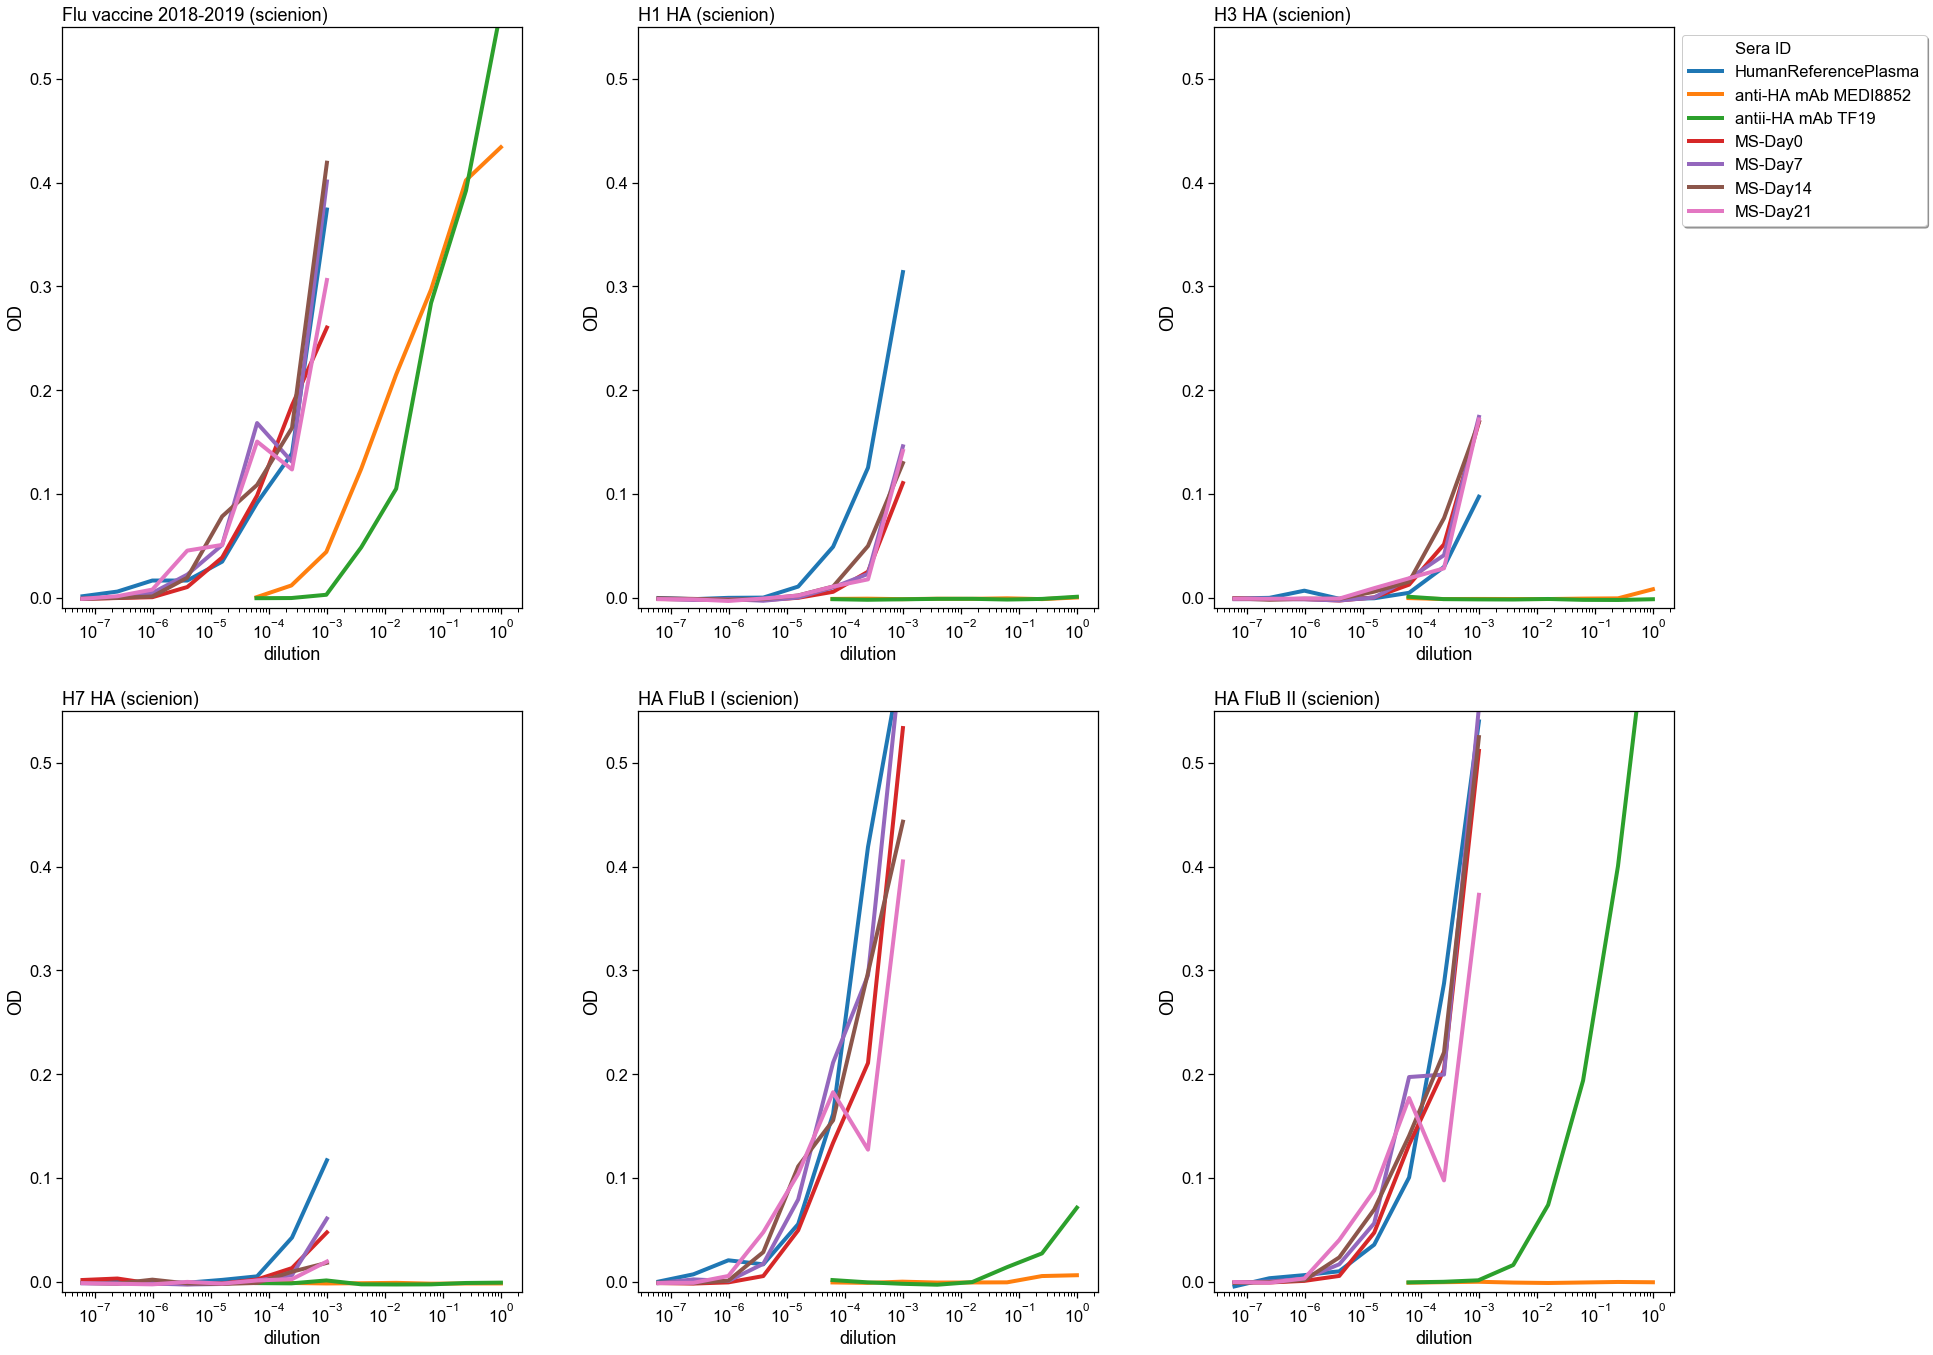

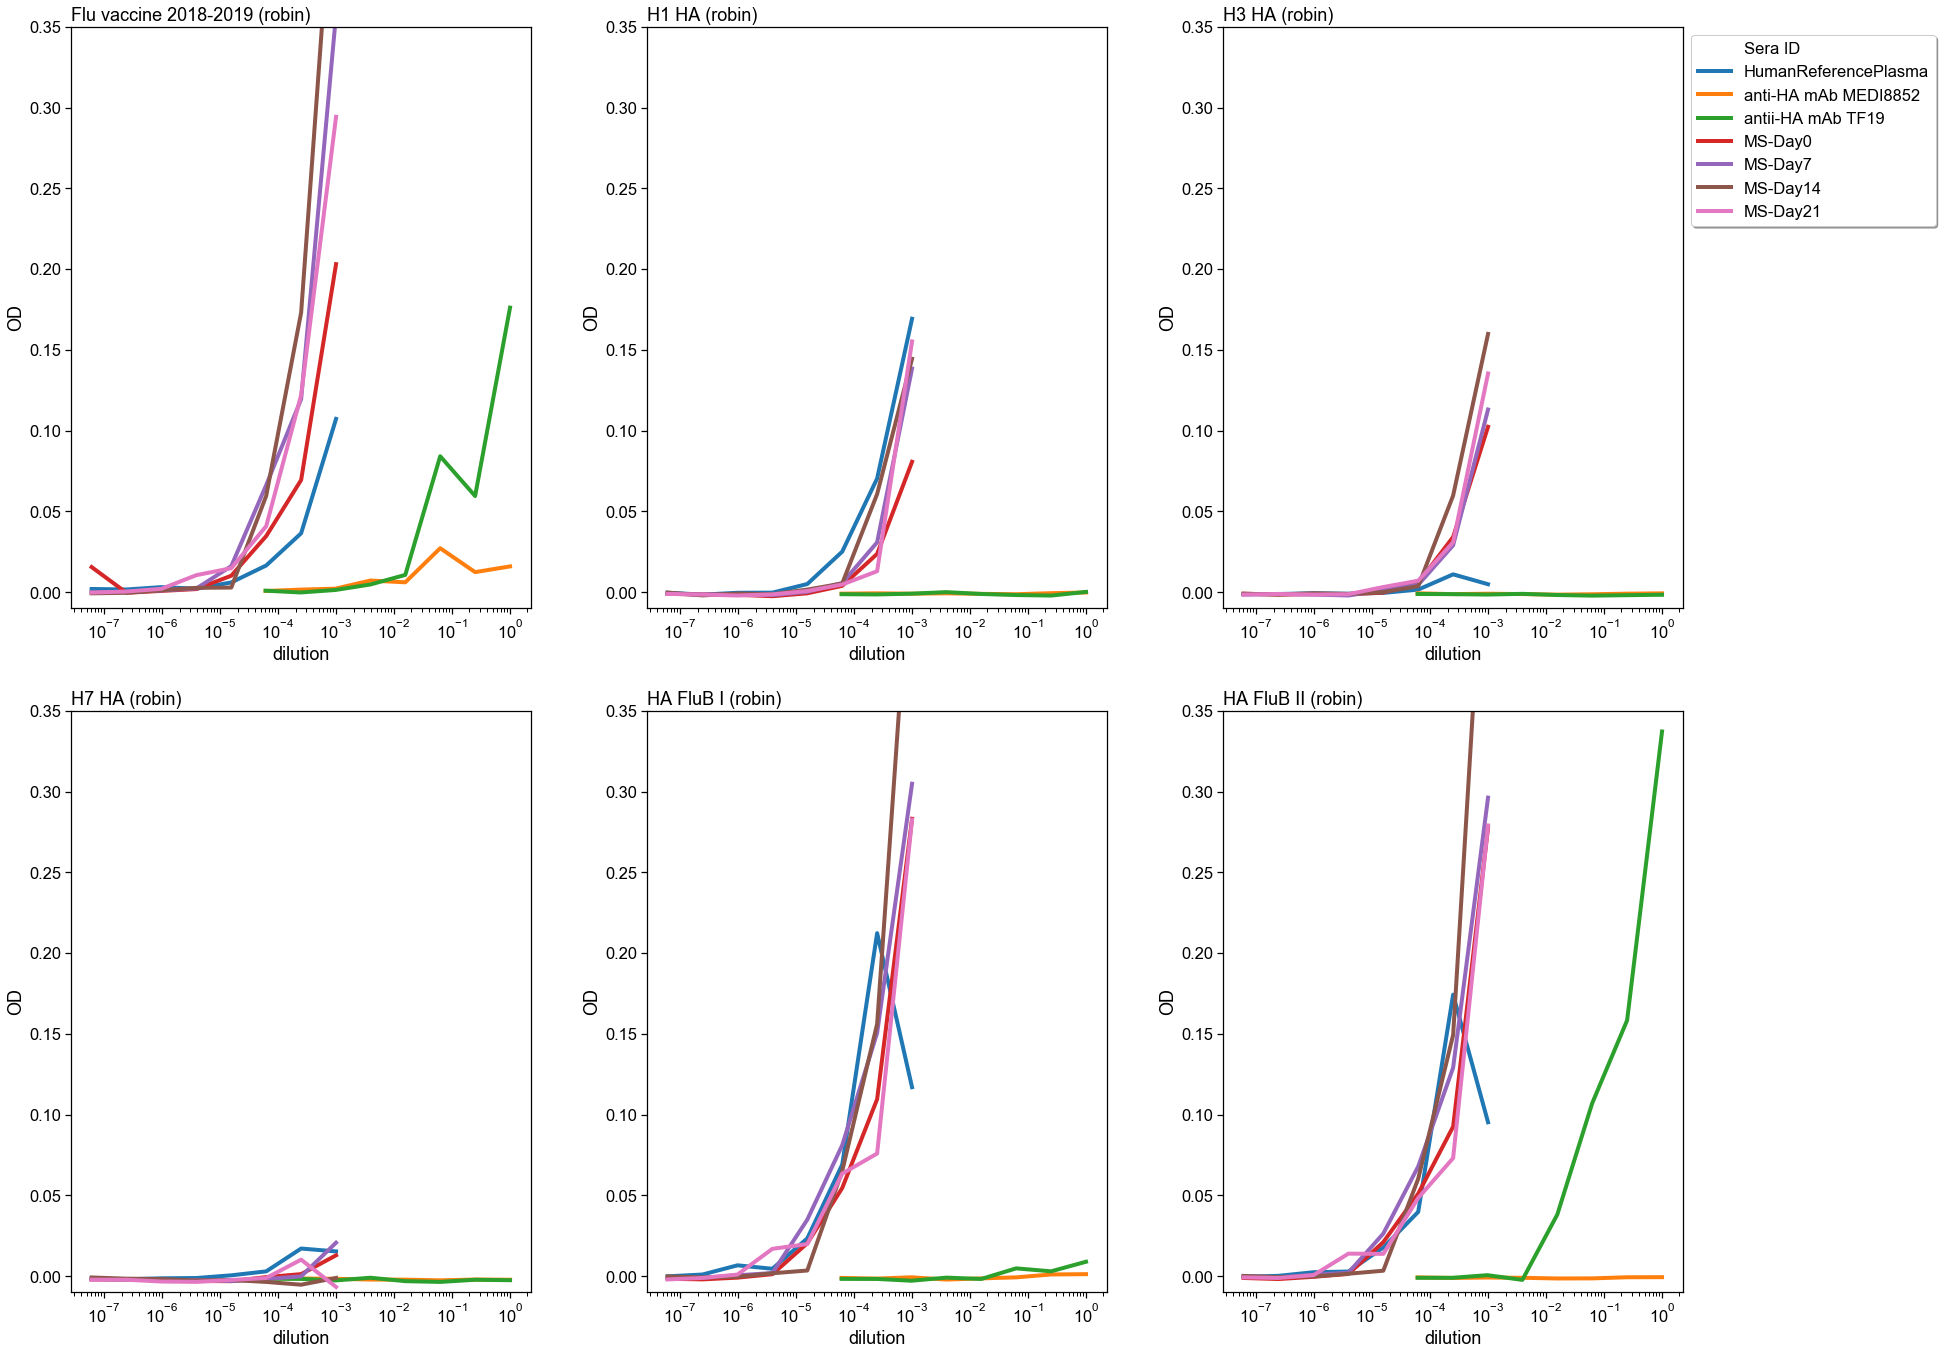

In [17]:
# Scienion data
# scienion_df['pipeline'] = 'scienion'
# robin_df['pipeline'] = 'robin'
subdf_sci = pd.DataFrame()
for s in range(len(seralist)):
    subdf_sci=subdf_sci.append(scienion_df[scienion_df['Sera ID'] == seralist[s]], ignore_index=True)
    
fig, ax = plt.subplots(2,3, figsize=(25,20))
fig.tight_layout(pad=4.0)
ax = ax.flatten()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4})

for a in range(len(antigenlist)):
    sub_df = subdf_sci[subdf_sci['antigen'] == antigenlist[a]]

    if not a==2:
        sns.lineplot(x="dilution", y="OD", hue='Sera ID', data=sub_df, ax = ax[a], legend=False, ci=None )
    else:
        sns.lineplot(x="dilution", y="OD", hue='Sera ID', data=sub_df, ax = ax[a], ci=None)
        lgd=ax[a].legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
        
    ax[a].set_title(antigenlist[a] + ' (scienion)',loc='left')
    ax[a].set(xscale="log")
    ax[a].set_ylim([-0.01,0.55])
plt.savefig('ODvsDilutionPerAb_Scienion.jpg',  dpi=200, bbox_inches='tight')


# Robin data
subdf_robin = pd.DataFrame()
for s in range(len(seralist)):
    subdf_robin=subdf_robin.append(robin_df[robin_df['Sera ID'] == seralist[s]], ignore_index=True)
    
linestyle=['ks-','kx-','ko-','rs-','rx-']
fig, ax = plt.subplots(2,3, figsize=(25,20))
fig.tight_layout(pad=4.0)
ax = ax.flatten()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4})
for a in range(len(antigenlist)):
    sub_df = subdf_robin[subdf_robin['antigen'] == antigenlist[a]]

    if not a==2:
        sns.lineplot(x="dilution", y="OD", hue='Sera ID', data=sub_df, ax = ax[a], legend=False, ci=None )
    else:
        sns.lineplot(x="dilution", y="OD", hue='Sera ID', data=sub_df, ax = ax[a], ci=None)
        lgd=ax[a].legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True, ncol=1)
        
    ax[a].set_title(antigenlist[a] + ' (robin)',loc='left')
    ax[a].set(xscale="log")
    ax[a].set_ylim([-0.01,0.35])
plt.savefig('ODvsDilutionPerAb_Robin.jpg',  dpi=200, bbox_inches='tight')
